In [2]:
# https://www.kaggle.com/tmdb/tmdb-movie-metadata
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

--2022-01-23 14:22:40--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv’

tmdb_5000_movies.cs 100%[===================>]   5.43M  3.64MB/s    in 1.5s    

2022-01-23 14:22:42 (3.64 MB/s) - ‘tmdb_5000_movies.csv’ saved [5698602/5698602]



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [4]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [5]:
df.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [6]:
df.shape

(4803, 20)

In [7]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [8]:
x = df.iloc[0]

In [9]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

In [10]:
df['spoken_languages'].value_counts()

[{"iso_639_1": "en", "name": "English"}]                                                                                                                                                                                      3171
[{"iso_639_1": "en", "name": "English"}, {"iso_639_1": "es", "name": "Espa\u00f1ol"}]                                                                                                                                          127
[{"iso_639_1": "en", "name": "English"}, {"iso_639_1": "fr", "name": "Fran\u00e7ais"}]                                                                                                                                         114
[]                                                                                                                                                                                                                              86
[{"iso_639_1": "es", "name": "Espa\u00f1ol"}, {"iso_639_1": "en", "name": "English"}]       

In [11]:
x['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [12]:
x['keywords']

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [29]:
j = json.loads(x['genres'])

In [30]:
genres = ' '.join(''.join(jj['name'].split()) for jj in j)

In [31]:
genres

'Action Adventure Fantasy ScienceFiction'

In [42]:
# return the genres and keywords of the inputted row as a combined string

def genres_and_keywords_to_string(row):
  genres = json.loads(row['genres'])
  genres = ' '.join(''.join(jj['name'].split()) for jj in genres)

  keywords = json.loads(row['keywords'])
  keywords = ' '.join(''.join(jj['name'].split()) for jj in keywords)

  return (f"{genres} {keywords}")


In [43]:
# create new column for the string representations of each movei

df['string'] = df.apply(genres_and_keywords_to_string, axis=1)

In [44]:
tfidf = TfidfVectorizer(max_features=2000)

In [45]:
X = tfidf.fit_transform(df['string'])

In [46]:
X.shape

(4803, 2000)

In [48]:
# create mapping from movie title -> index (in df)

movie2idx = pd.Series(df.index, index=df['title'])
movie2idx

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [52]:
idx = movie2idx['Star Wars']

In [53]:
query = X[idx]

In [55]:
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [56]:
scores = cosine_similarity(query,X)

In [61]:
scores = scores.flatten()

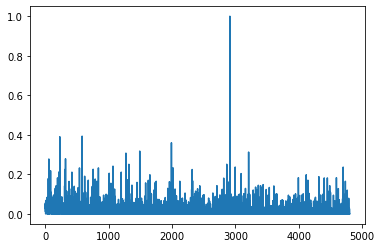

In [62]:
plt.plot(scores)

In [65]:
(-scores).argsort()

array([4802, 4801, 4800, ..., 1596, 1594, 2401])

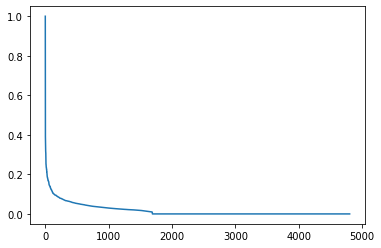

In [68]:
plt.plot(scores[(-scores).argsort()])

In [69]:
# get top 5 matches, excluding self (which is the max score)

recommended_idx = (-scores).argsort()[1:6]

In [88]:
# create function that generates recommendations
def recommend(movie):
  idx = movie2idx[movie]
  if type(idx) == pd.Series:
    idx = idx.iloc[0]

  query = X[idx]

  scores = cosine_similarity(query,X)
  scores = scores.flatten()

  recommendations_idx = (-scores).argsort()[1:6]
  return(df['title'].iloc[recommendations_idx])

In [96]:
recommend("Runaway Bride")

4115                    House of D
2325    My Big Fat Greek Wedding 2
4604         It Happened One Night
3313                  An Education
2689            Our Family Wedding
Name: title, dtype: object